## Vesuvius Challenge - Ink Detection Training Notebook

### Setup

In [1]:
# Pretrained weights
# ref - https://github.com/kenshohara/3D-ResNets-PyTorch
!pip install gdown
!gdown 1fFN5J2He6eTqMPRl_M9gFtFfpUmhtQc9

# Utility packages for reading and visualizing volumes
!pip install zarr imageio-ffmpeg

# save model checkpoints
!mkdir ./ckpts

Downloading...
From (uriginal): https://drive.google.com/uc?id=1fFN5J2He6eTqMPRl_M9gFtFfpUmhtQc9
From (redirected): https://drive.google.com/uc?id=1fFN5J2He6eTqMPRl_M9gFtFfpUmhtQc9&confirm=t&uuid=8a11ec61-70d1-49f1-bfdd-7beb6c0ae6f5
To: /kaggle/working/r3d34_K_200ep.pth
100%|████████████████████████████████████████| 511M/511M [00:06<00:00, 80.4MB/s]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.8/185.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 45.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 74.5 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=09057081867ac63b460755f91cfb1cd1a6c1e8381a7db33c932ea7b1f6e900d4
  Stored in directory: /root/.cache/pip/wheels/e2/97/c4/5537ba28215ed3508783dc23c1fb59e17f00722317e4edeac0
Successfully built asciitree


In [2]:
import os
import gc
import sys
import zarr
import random
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

sys.path.append("/kaggle/input/resnet3d")
from resnet3d import generate_model

### Config

In [3]:
LR = 1e-4
EPOCHS = 50
BATCH_SIZE = 32
CROP_SIZE = 256
Z_START = 24
Z_DIMS = 16
TRAIN_FRAGMENTS = ["2", "3"]
TEST_FRAGMENT = "1"
metric_direction = 'maximize'

### Load data

In [4]:
FRAGMENTS_ZARR = {
    "1" : zarr.open("/kaggle/input/vesuvius-zarr-files/train-1.zarr", mode="r"),
    "2" : zarr.open("/kaggle/input/vesuvius-zarr-files/train-2.zarr", mode="r"),
    "3" : zarr.open("/kaggle/input/vesuvius-zarr-files/train-3.zarr", mode="r")
}

FRAGMENTS_SHAPE = {k : v.mask.shape for k, v in FRAGMENTS_ZARR.items()}

### Visualise input

In [5]:
fragment = FRAGMENTS_ZARR["1"]
x, y = 2000, 2000

fragment_cropped = fragment.surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, Z_START:Z_START+Z_DIMS]
imageio.mimwrite("fragment_crop.mp4", fragment_cropped.transpose(2, 0, 1), "ffmpeg")
Video("fragment_crop.mp4", height=256, width=256)

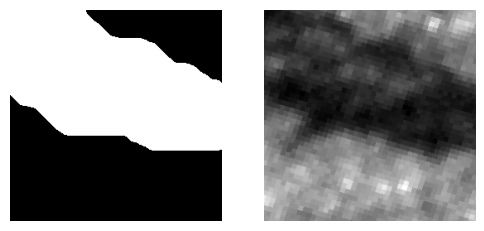

In [6]:
mask_cropped = fragment.truth[y:y+CROP_SIZE, x:x+CROP_SIZE]
ir_cropped = fragment.infrared[y:y+CROP_SIZE, x:x+CROP_SIZE]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(mask_cropped, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ir_cropped, cmap="gray")
plt.axis("off")
plt.show()

In [7]:
del fragment, fragment_cropped, mask_cropped, ir_cropped
gc.collect()

3955

### Dataloaders

In [8]:
class VesuviusTrain(Dataset):
    def __init__(self, fragments):
        self.fragments = fragments
        self.xys = []
        
        for fragment in fragments:
            H, W = FRAGMENTS_SHAPE[fragment]
            for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
                for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                    self.xys.append((fragment, x, y, W, H))
        
    def __getitem__(self, i):
        fragment, x1, y1, W, H = self.xys[i]
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        x_offset = random.randint(-32 if x1 != 0 else 0, 32)
        y_offset = random.randint(-32 if y1 != 0 else 0, 32)
        
        x1 += x_offset
        y1 += y_offset
        
        x2 = x1 + CROP_SIZE
        y2 = y1 + CROP_SIZE
        
        if x2 > W:
            x1 -= x_offset
            x2 -= x_offset
            
        if y2 > H:
            y1 -= y_offset
            y2 -= y_offset
        
        frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
        if random.random() > 0.5:
            frag_crop = np.flip(frag_crop, axis=1).copy()
            mask_crop = np.flip(mask_crop, axis=1).copy()

        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
        frag_crop = frag_crop/65535.0
        frag_crop = (frag_crop - 0.45)/0.225
        
        mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        return frag_crop, mask_crop

    def __len__(self):
        return len(self.xys)

In [9]:
class VesuviusVal(Dataset):
    def __init__(self, fragment):
        self.fragment = FRAGMENTS_ZARR[fragment]
        self.xys = []
        
        H, W = FRAGMENTS_SHAPE[fragment]
        for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
            for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                self.xys.append((x, y))
                
    def __getitem__(self, i):
        x1, y1 = self.xys[i]
        x2, y2 = x1+CROP_SIZE, y1+CROP_SIZE
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        frag_crop = self.fragment.surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = self.fragment.truth[y1:y2, x1:x2]

        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
        frag_crop = frag_crop/65535.0
        frag_crop = (frag_crop - 0.45)/0.225
        
        mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        return frag_crop, mask_crop, torch.tensor([x1, y1, x2, y2], dtype=torch.int32)

    def __len__(self):
        return len(self.xys)

In [10]:
dataset_train = VesuviusTrain(TRAIN_FRAGMENTS)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=True, pin_memory=True, drop_last=True)
n_train = len(dataloader_train)

dataset_valid = VesuviusVal(TEST_FRAGMENT)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=False, pin_memory=True, drop_last=False)
n_valid = len(dataloader_valid)

In [11]:
# len(dataset_train)

### Model
* Encoder is a 3D ResNet model. The architecture has been modified to remove temporal downsampling between blocks.
* A 2D decoder is used for predicting the segmentation map.
* The encoder feature maps are average pooled over the Z dimension before passing it to the decoder.

In [12]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask


class SegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = generate_model(model_depth=34, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))
        
        
def build_model():

    model = SegModel()

    return model

In [13]:
model = SegModel()
model.load_pretrained_weights(torch.load("r3d34_K_200ep.pth")["state_dict"])
model = nn.DataParallel(model, device_ids=[0, 1])
model = model.cuda()

_IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.weight', 'fc.bias'])


In [14]:
# class EnsembleModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.model = nn.ModuleList()
#         for fold in [1, 2, 3]:
#             _model = build_model()
#             _model.load_pretrained_weights(torch.load("r3d34_K_200ep.pth")["state_dict"])
#             #_model.to(device)

# #             model_path = f'/kaggle/input/vesuvius-models-public/{CFG.exp_name}/vesuvius-models/Unet_fold{fold}_best.pth'
# #             state = torch.load(model_path)['model']
# #             _model.load_state_dict(state)
#             _model.train()

#             self.model.append(_model)
    
#     def forward(self,x):
#         output=[]
#         for m in self.model:
#             output.append(m(x))
#         output=torch.stack(output,dim=0).mean(0)
#         return output

In [15]:
# model = EnsembleModel()
# model = nn.DataParallel(model, device_ids=[0, 1])
# model = model.cuda()

### Competition metric (F0.5 Score)

In [16]:
# ref - https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
def fbeta_score(preds, targets, threshold, beta=1, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice
# def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
#     """
#     https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
#     """
#     y_true_count = targets.sum()
#     ctp = preds[targets==1].sum()
#     cfp = preds[targets==0].sum()
#     beta_squared = beta * beta

#     c_precision = ctp / (ctp + cfp + smooth)
#     c_recall = ctp / (y_true_count + smooth)
#     dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

#     return dice

# def calc_fbeta(mask, mask_pred):
#     mask = mask.astype(int).flatten()
# #     mask = mask.flatten()
#     mask_pred = mask_pred.flatten()

#     best_th = 0
#     best_dice = 0
#     for th in np.array(range(10, 50+1, 5)) / 100:
        
#         # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
#         dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
#         print(f'th: {th}, fbeta: {dice}')

#         if dice > best_dice:
#             best_dice = dice
#             best_th = th
    
#     Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
#     return best_dice, best_th


# def calc_cv(mask_gt, mask_pred):
#     best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

#     return best_dice, best_th

# 1. 验证集使用TTA

In [17]:
TTA = True
def TTA(x,model):
    #x.shape=(batch,c,h,w)
    if TTA:
        shape=x.shape
        x=[x,*[torch.rot90(x,k=i,dims=(-2,-1)) for i in range(1,4)]]
        x=torch.cat(x,dim=0)
        x=model(x)
        x=torch.sigmoid(x)
        x=x.reshape(4,shape[0],*shape[2:])
        x=[torch.rot90(x[i],k=-i,dims=(-2,-1)) for i in range(4)]
        x=torch.stack(x,dim=0)
        return x.mean(0)
    else :
        x=model(x)
        x=torch.sigmoid(x)
        return x

### Training

1. # LOSS

In [18]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=e1bb0e4689f55b94ba6942e35309bd0c27f4f8113114757a04eefb97b6b30785
  Stored in directory: /root/.cache/pip/wheels/96/3f/5f/13976445f67f3b4e77b054e65f7f4c39016e92e8358fe088db
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=b59f406321176efc006da76a32cf14161065c8758dd62077f724dba6b4285560
  Stored in directory: /root/.cache/pip/wheels/4f/89/a3/5cf59e30a8a75c917c313f14da0f6209be2d147e3160b985d6
Successfully built efficientn

In [19]:
import segmentation_models_pytorch as smp

In [20]:
DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
#     return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

In [21]:
scaler = amp.GradScaler()
# criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                                steps_per_epoch=10, epochs=EPOCHS//10,
                                                pct_start=0.1)

In [22]:
gt_mask = torch.from_numpy(np.asarray(FRAGMENTS_ZARR[TEST_FRAGMENT].truth)).float().cuda()
# gt_mask = 
gt_shape = FRAGMENTS_SHAPE[TEST_FRAGMENT]

In [23]:
type(gt_mask)

torch.Tensor

In [24]:
# best_loss=1000
if metric_direction == 'minimize':
    best_score = np.inf
elif metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(1, EPOCHS+1):
    model.train()
    cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

    for i, (fragments, masks) in pbar_train:
        fragments, masks = fragments.cuda(), masks.cuda()
        optimizer.zero_grad()
        with amp.autocast():
            pred_masks = model(fragments)
            loss = criterion(pred_masks, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            mloss_train += loss.detach().item()

        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
                                                              f"Loss: {mloss_train / (i + 1):.4f}"))
        
    scheduler.step()
    model.eval()
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
    for i, (fragments, masks, xys) in pbar_val:
        fragments, masks = fragments.cuda(), masks.cuda()
        with torch.no_grad():
#             print(fragments.shape)
#             fragments=TTA(fragments,model)
            pred_masks = model(fragments)
            mloss_val += criterion(pred_masks, masks).item()
            pred_masks = torch.sigmoid(pred_masks)
        
        for j, xy in enumerate(xys):
            final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

        pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
    
    
#     final_pred_mask = final_pred_mask.cpu().numpy()
    
#     best_dice, best_th = calc_cv(gt_mask, final_pred_mask)
    
#     score = best_dice
    
#     if metric_direction == 'minimize':
#         update_best = score < best_score
#     elif metric_direction == 'maximize':
#         update_best = score > best_score
        
        
        
#     if update_best:
#         best_loss = avg_val_loss
#         best_score = score

        
#         torch.save({'model': model.state_dict(),
#                     'preds': mask_pred},
#                     CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')
    for threshold in np.arange(0.2, 0.65, 0.05):
        fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
        print(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")
    
    if epoch >= 10:
        torch.save(model.module.state_dict(), f"./ckpts/resnet34_3d_seg_epoch_{epoch}.pt")

    if epoch == 30:
        break

    print()

Epoch 1/50  Mem : 9.05GB  LR : 4.00E-06  Loss: 0.7021: 100%|██████████| 84/84 [02:37<00:00,  1.88s/it]
Val Loss: 0.6569: 100%|██████████| 24/24 [00:48<00:00,  2.00s/it]


Threshold : 0.20	FBeta : 0.203592
Threshold : 0.25	FBeta : 0.241138
Threshold : 0.30	FBeta : 0.291479
Threshold : 0.35	FBeta : 0.315835
Threshold : 0.40	FBeta : 0.325633
Threshold : 0.45	FBeta : 0.332911
Threshold : 0.50	FBeta : 0.346255
Threshold : 0.55	FBeta : 0.366821
Threshold : 0.60	FBeta : 0.374458



Epoch 2/50  Mem : 11.2GB  LR : 1.81E-05  Loss: 0.6562: 100%|██████████| 84/84 [02:22<00:00,  1.69s/it]
Val Loss: 0.6905: 100%|██████████| 24/24 [00:46<00:00,  1.96s/it]


Threshold : 0.20	FBeta : 0.213688
Threshold : 0.25	FBeta : 0.317485
Threshold : 0.30	FBeta : 0.329006
Threshold : 0.35	FBeta : 0.332901
Threshold : 0.40	FBeta : 0.339723
Threshold : 0.45	FBeta : 0.354773
Threshold : 0.50	FBeta : 0.366863
Threshold : 0.55	FBeta : 0.370393
Threshold : 0.60	FBeta : 0.368177



Epoch 3/50  Mem : 11.2GB  LR : 5.20E-05  Loss: 0.6102: 100%|██████████| 84/84 [02:19<00:00,  1.67s/it]
Val Loss: 0.6669: 100%|██████████| 24/24 [00:46<00:00,  1.96s/it]


Threshold : 0.20	FBeta : 0.320213
Threshold : 0.25	FBeta : 0.330760
Threshold : 0.30	FBeta : 0.339546
Threshold : 0.35	FBeta : 0.353758
Threshold : 0.40	FBeta : 0.365585
Threshold : 0.45	FBeta : 0.375260
Threshold : 0.50	FBeta : 0.382382
Threshold : 0.55	FBeta : 0.390403
Threshold : 0.60	FBeta : 0.398524



Epoch 4/50  Mem : 11.2GB  LR : 8.59E-05  Loss: 0.5757: 100%|██████████| 84/84 [02:19<00:00,  1.66s/it]
Val Loss: 0.5918: 100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


Threshold : 0.20	FBeta : 0.339477
Threshold : 0.25	FBeta : 0.367286
Threshold : 0.30	FBeta : 0.384360
Threshold : 0.35	FBeta : 0.394333
Threshold : 0.40	FBeta : 0.400004
Threshold : 0.45	FBeta : 0.404634
Threshold : 0.50	FBeta : 0.409126
Threshold : 0.55	FBeta : 0.414395
Threshold : 0.60	FBeta : 0.418919



Epoch 5/50  Mem : 11.2GB  LR : 1.00E-04  Loss: 0.5382: 100%|██████████| 84/84 [02:19<00:00,  1.66s/it]
Val Loss: 0.7739: 100%|██████████| 24/24 [00:47<00:00,  1.98s/it]


Threshold : 0.20	FBeta : 0.332409
Threshold : 0.25	FBeta : 0.339832
Threshold : 0.30	FBeta : 0.345545
Threshold : 0.35	FBeta : 0.349860
Threshold : 0.40	FBeta : 0.353651
Threshold : 0.45	FBeta : 0.357416
Threshold : 0.50	FBeta : 0.361851
Threshold : 0.55	FBeta : 0.368165
Threshold : 0.60	FBeta : 0.374667



Epoch 6/50  Mem : 11.2GB  LR : 9.99E-05  Loss: 0.5007: 100%|██████████| 84/84 [02:20<00:00,  1.67s/it]
Val Loss: 0.5082: 100%|██████████| 24/24 [00:46<00:00,  1.96s/it]


Threshold : 0.20	FBeta : 0.434362
Threshold : 0.25	FBeta : 0.431473
Threshold : 0.30	FBeta : 0.420090
Threshold : 0.35	FBeta : 0.409234
Threshold : 0.40	FBeta : 0.398655
Threshold : 0.45	FBeta : 0.387531
Threshold : 0.50	FBeta : 0.373458
Threshold : 0.55	FBeta : 0.352829
Threshold : 0.60	FBeta : 0.330292



Epoch 7/50  Mem : 11.2GB  LR : 9.95E-05  Loss: 0.4830: 100%|██████████| 84/84 [02:19<00:00,  1.66s/it]
Val Loss: 0.5479: 100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


Threshold : 0.20	FBeta : 0.267614
Threshold : 0.25	FBeta : 0.182762
Threshold : 0.30	FBeta : 0.155755
Threshold : 0.35	FBeta : 0.136450
Threshold : 0.40	FBeta : 0.121226
Threshold : 0.45	FBeta : 0.107510
Threshold : 0.50	FBeta : 0.082077
Threshold : 0.55	FBeta : 0.061922
Threshold : 0.60	FBeta : 0.050782



Epoch 8/50  Mem : 11.2GB  LR : 9.89E-05  Loss: 0.4570: 100%|██████████| 84/84 [02:20<00:00,  1.67s/it]
Val Loss: 0.4808: 100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


Threshold : 0.20	FBeta : 0.456639
Threshold : 0.25	FBeta : 0.447457
Threshold : 0.30	FBeta : 0.440336
Threshold : 0.35	FBeta : 0.433508
Threshold : 0.40	FBeta : 0.425937
Threshold : 0.45	FBeta : 0.417235
Threshold : 0.50	FBeta : 0.399704
Threshold : 0.55	FBeta : 0.376441
Threshold : 0.60	FBeta : 0.359556



Epoch 9/50  Mem : 11.2GB  LR : 9.81E-05  Loss: 0.4412: 100%|██████████| 84/84 [02:20<00:00,  1.67s/it]
Val Loss: 0.4719: 100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


Threshold : 0.20	FBeta : 0.441569
Threshold : 0.25	FBeta : 0.445106
Threshold : 0.30	FBeta : 0.446285
Threshold : 0.35	FBeta : 0.446228
Threshold : 0.40	FBeta : 0.445137
Threshold : 0.45	FBeta : 0.443387
Threshold : 0.50	FBeta : 0.430704
Threshold : 0.55	FBeta : 0.416207
Threshold : 0.60	FBeta : 0.402865



Epoch 10/50  Mem : 11.2GB  LR : 9.70E-05  Loss: 0.4210: 100%|██████████| 84/84 [02:19<00:00,  1.66s/it]
Val Loss: 0.5703: 100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


Threshold : 0.20	FBeta : 0.131251
Threshold : 0.25	FBeta : 0.111554
Threshold : 0.30	FBeta : 0.099055
Threshold : 0.35	FBeta : 0.090268
Threshold : 0.40	FBeta : 0.083160
Threshold : 0.45	FBeta : 0.076971
Threshold : 0.50	FBeta : 0.068696
Threshold : 0.55	FBeta : 0.059292
Threshold : 0.60	FBeta : 0.051168



Epoch 11/50  Mem : 11.2GB  LR : 9.57E-05  Loss: 0.4093: 100%|██████████| 84/84 [02:21<00:00,  1.68s/it]
Val Loss: 0.5435: 100%|██████████| 24/24 [00:46<00:00,  1.96s/it]


Threshold : 0.20	FBeta : 0.247148
Threshold : 0.25	FBeta : 0.221092
Threshold : 0.30	FBeta : 0.204815
Threshold : 0.35	FBeta : 0.192233
Threshold : 0.40	FBeta : 0.182056
Threshold : 0.45	FBeta : 0.172290
Threshold : 0.50	FBeta : 0.158899
Threshold : 0.55	FBeta : 0.144656
Threshold : 0.60	FBeta : 0.131553



Epoch 12/50  Mem : 11.2GB  LR : 9.41E-05  Loss: 0.3883: 100%|██████████| 84/84 [02:20<00:00,  1.67s/it]
Val Loss: 0.9988: 100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


Threshold : 0.20	FBeta : 0.360715
Threshold : 0.25	FBeta : 0.365922
Threshold : 0.30	FBeta : 0.369421
Threshold : 0.35	FBeta : 0.371981
Threshold : 0.40	FBeta : 0.374021
Threshold : 0.45	FBeta : 0.375869
Threshold : 0.50	FBeta : 0.378206
Threshold : 0.55	FBeta : 0.381125
Threshold : 0.60	FBeta : 0.384125



Epoch 13/50  Mem : 11.2GB  LR : 9.24E-05  Loss: 0.3838: 100%|██████████| 84/84 [02:20<00:00,  1.67s/it]
Val Loss: 1.2115: 100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


Threshold : 0.20	FBeta : 0.332502
Threshold : 0.25	FBeta : 0.333934
Threshold : 0.30	FBeta : 0.335144
Threshold : 0.35	FBeta : 0.336237
Threshold : 0.40	FBeta : 0.337302
Threshold : 0.45	FBeta : 0.338451
Threshold : 0.50	FBeta : 0.340157
Threshold : 0.55	FBeta : 0.342314
Threshold : 0.60	FBeta : 0.344717



Epoch 14/50  Mem : 11.2GB  LR : 9.05E-05  Loss: 0.3623: 100%|██████████| 84/84 [02:20<00:00,  1.68s/it]
Val Loss: 0.4661: 100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


Threshold : 0.20	FBeta : 0.437065
Threshold : 0.25	FBeta : 0.425465
Threshold : 0.30	FBeta : 0.416519
Threshold : 0.35	FBeta : 0.408721
Threshold : 0.40	FBeta : 0.401293
Threshold : 0.45	FBeta : 0.392350
Threshold : 0.50	FBeta : 0.372456
Threshold : 0.55	FBeta : 0.352973
Threshold : 0.60	FBeta : 0.336742



Epoch 15/50  Mem : 11.2GB  LR : 8.83E-05  Loss: 0.3576: 100%|██████████| 84/84 [02:19<00:00,  1.67s/it]
Val Loss: 1.0748: 100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


Threshold : 0.20	FBeta : 0.350822
Threshold : 0.25	FBeta : 0.353574
Threshold : 0.30	FBeta : 0.355569
Threshold : 0.35	FBeta : 0.357264
Threshold : 0.40	FBeta : 0.358947
Threshold : 0.45	FBeta : 0.360713
Threshold : 0.50	FBeta : 0.365633
Threshold : 0.55	FBeta : 0.369374
Threshold : 0.60	FBeta : 0.372595



Epoch 16/50  Mem : 11.2GB  LR : 8.60E-05  Loss: 0.3383: 100%|██████████| 84/84 [02:19<00:00,  1.66s/it]
Val Loss: 0.5947: 100%|██████████| 24/24 [00:47<00:00,  1.97s/it]


Threshold : 0.20	FBeta : 0.397372
Threshold : 0.25	FBeta : 0.401405
Threshold : 0.30	FBeta : 0.404558
Threshold : 0.35	FBeta : 0.407444
Threshold : 0.40	FBeta : 0.410087
Threshold : 0.45	FBeta : 0.412878
Threshold : 0.50	FBeta : 0.417265
Threshold : 0.55	FBeta : 0.422168
Threshold : 0.60	FBeta : 0.426445



Epoch 17/50  Mem : 11.2GB  LR : 8.35E-05  Loss: 0.3247: 100%|██████████| 84/84 [02:20<00:00,  1.68s/it]
Val Loss: 0.4761: 100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


Threshold : 0.20	FBeta : 0.423728
Threshold : 0.25	FBeta : 0.418591
Threshold : 0.30	FBeta : 0.413632
Threshold : 0.35	FBeta : 0.408405
Threshold : 0.40	FBeta : 0.403007
Threshold : 0.45	FBeta : 0.396394
Threshold : 0.50	FBeta : 0.384977
Threshold : 0.55	FBeta : 0.371734
Threshold : 0.60	FBeta : 0.357853



Epoch 18/50  Mem : 11.2GB  LR : 8.08E-05  Loss: 0.3229: 100%|██████████| 84/84 [02:19<00:00,  1.66s/it]
Val Loss: 0.5097: 100%|██████████| 24/24 [00:46<00:00,  1.94s/it]


Threshold : 0.20	FBeta : 0.362714
Threshold : 0.25	FBeta : 0.353615
Threshold : 0.30	FBeta : 0.345692
Threshold : 0.35	FBeta : 0.339495
Threshold : 0.40	FBeta : 0.333813
Threshold : 0.45	FBeta : 0.328250
Threshold : 0.50	FBeta : 0.321550
Threshold : 0.55	FBeta : 0.312896
Threshold : 0.60	FBeta : 0.301833



Epoch 19/50  Mem : 11.2GB  LR : 7.80E-05  Loss: 0.3042: 100%|██████████| 84/84 [02:20<00:00,  1.67s/it]
Val Loss: 0.4462: 100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


Threshold : 0.20	FBeta : 0.482840
Threshold : 0.25	FBeta : 0.482317
Threshold : 0.30	FBeta : 0.481498
Threshold : 0.35	FBeta : 0.480785
Threshold : 0.40	FBeta : 0.479981
Threshold : 0.45	FBeta : 0.478887
Threshold : 0.50	FBeta : 0.477678
Threshold : 0.55	FBeta : 0.475782
Threshold : 0.60	FBeta : 0.473053



Epoch 20/50  Mem : 11.2GB  LR : 7.50E-05  Loss: 0.2953: 100%|██████████| 84/84 [02:20<00:00,  1.67s/it]
Val Loss: 0.5352: 100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


Threshold : 0.20	FBeta : 0.299238
Threshold : 0.25	FBeta : 0.289131
Threshold : 0.30	FBeta : 0.281049
Threshold : 0.35	FBeta : 0.274054
Threshold : 0.40	FBeta : 0.267827
Threshold : 0.45	FBeta : 0.261712
Threshold : 0.50	FBeta : 0.255427
Threshold : 0.55	FBeta : 0.248419
Threshold : 0.60	FBeta : 0.239464



Epoch 21/50  Mem : 11.2GB  LR : 7.19E-05  Loss: 0.2936: 100%|██████████| 84/84 [02:20<00:00,  1.67s/it]
Val Loss: 0.4902: 100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


Threshold : 0.20	FBeta : 0.407940
Threshold : 0.25	FBeta : 0.398056
Threshold : 0.30	FBeta : 0.389122
Threshold : 0.35	FBeta : 0.381217
Threshold : 0.40	FBeta : 0.373641
Threshold : 0.45	FBeta : 0.365735
Threshold : 0.50	FBeta : 0.356200
Threshold : 0.55	FBeta : 0.345244
Threshold : 0.60	FBeta : 0.332955



Epoch 22/50  Mem : 11.2GB  LR : 6.87E-05  Loss: 0.2766: 100%|██████████| 84/84 [02:20<00:00,  1.67s/it]
Val Loss: 0.4987: 100%|██████████| 24/24 [00:46<00:00,  1.94s/it]


Threshold : 0.20	FBeta : 0.375424
Threshold : 0.25	FBeta : 0.363406
Threshold : 0.30	FBeta : 0.352851
Threshold : 0.35	FBeta : 0.343119
Threshold : 0.40	FBeta : 0.334436
Threshold : 0.45	FBeta : 0.326159
Threshold : 0.50	FBeta : 0.316802
Threshold : 0.55	FBeta : 0.306498
Threshold : 0.60	FBeta : 0.293673



Epoch 23/50  Mem : 11.2GB  LR : 6.55E-05  Loss: 0.2630: 100%|██████████| 84/84 [02:19<00:00,  1.67s/it]
Val Loss: 0.4665: 100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


Threshold : 0.20	FBeta : 0.430648
Threshold : 0.25	FBeta : 0.426256
Threshold : 0.30	FBeta : 0.422070
Threshold : 0.35	FBeta : 0.418310
Threshold : 0.40	FBeta : 0.414689
Threshold : 0.45	FBeta : 0.411126
Threshold : 0.50	FBeta : 0.407341
Threshold : 0.55	FBeta : 0.403252
Threshold : 0.60	FBeta : 0.398084



Epoch 24/50  Mem : 11.2GB  LR : 6.21E-05  Loss: 0.2603: 100%|██████████| 84/84 [02:19<00:00,  1.67s/it]
Val Loss: 0.6500: 100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


Threshold : 0.20	FBeta : 0.434380
Threshold : 0.25	FBeta : 0.437227
Threshold : 0.30	FBeta : 0.439475
Threshold : 0.35	FBeta : 0.441387
Threshold : 0.40	FBeta : 0.443192
Threshold : 0.45	FBeta : 0.444819
Threshold : 0.50	FBeta : 0.446323
Threshold : 0.55	FBeta : 0.447892
Threshold : 0.60	FBeta : 0.449687



Epoch 25/50  Mem : 11.2GB  LR : 5.87E-05  Loss: 0.2548: 100%|██████████| 84/84 [02:20<00:00,  1.68s/it]
Val Loss: 0.5001: 100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


Threshold : 0.20	FBeta : 0.367825
Threshold : 0.25	FBeta : 0.357998
Threshold : 0.30	FBeta : 0.349951
Threshold : 0.35	FBeta : 0.342840
Threshold : 0.40	FBeta : 0.336176
Threshold : 0.45	FBeta : 0.329898
Threshold : 0.50	FBeta : 0.322835
Threshold : 0.55	FBeta : 0.315049
Threshold : 0.60	FBeta : 0.306231



Epoch 26/50  Mem : 11.2GB  LR : 5.52E-05  Loss: 0.2455: 100%|██████████| 84/84 [02:21<00:00,  1.68s/it]
Val Loss: 0.4632: 100%|██████████| 24/24 [00:46<00:00,  1.94s/it]


Threshold : 0.20	FBeta : 0.480436
Threshold : 0.25	FBeta : 0.481298
Threshold : 0.30	FBeta : 0.481873
Threshold : 0.35	FBeta : 0.482343
Threshold : 0.40	FBeta : 0.482621
Threshold : 0.45	FBeta : 0.482652
Threshold : 0.50	FBeta : 0.482710
Threshold : 0.55	FBeta : 0.482634
Threshold : 0.60	FBeta : 0.482295



Epoch 27/50  Mem : 11.2GB  LR : 5.17E-05  Loss: 0.2408: 100%|██████████| 84/84 [02:20<00:00,  1.67s/it]
Val Loss: 0.4916: 100%|██████████| 24/24 [00:47<00:00,  1.96s/it]


Threshold : 0.20	FBeta : 0.413082
Threshold : 0.25	FBeta : 0.406534
Threshold : 0.30	FBeta : 0.401280
Threshold : 0.35	FBeta : 0.396729
Threshold : 0.40	FBeta : 0.392595
Threshold : 0.45	FBeta : 0.388629
Threshold : 0.50	FBeta : 0.384737
Threshold : 0.55	FBeta : 0.380428
Threshold : 0.60	FBeta : 0.375532



Epoch 28/50  Mem : 11.2GB  LR : 4.83E-05  Loss: 0.2263: 100%|██████████| 84/84 [02:20<00:00,  1.67s/it]
Val Loss: 0.4310: 100%|██████████| 24/24 [00:47<00:00,  1.96s/it]


Threshold : 0.20	FBeta : 0.499153
Threshold : 0.25	FBeta : 0.496668
Threshold : 0.30	FBeta : 0.493919
Threshold : 0.35	FBeta : 0.491260
Threshold : 0.40	FBeta : 0.488541
Threshold : 0.45	FBeta : 0.486145
Threshold : 0.50	FBeta : 0.483470
Threshold : 0.55	FBeta : 0.480468
Threshold : 0.60	FBeta : 0.477215



Epoch 29/50  Mem : 11.2GB  LR : 4.48E-05  Loss: 0.2203: 100%|██████████| 84/84 [02:21<00:00,  1.68s/it]
Val Loss: 0.4899: 100%|██████████| 24/24 [00:46<00:00,  1.96s/it]


Threshold : 0.20	FBeta : 0.442157
Threshold : 0.25	FBeta : 0.440555
Threshold : 0.30	FBeta : 0.439069
Threshold : 0.35	FBeta : 0.437621
Threshold : 0.40	FBeta : 0.436139
Threshold : 0.45	FBeta : 0.434582
Threshold : 0.50	FBeta : 0.432957
Threshold : 0.55	FBeta : 0.431088
Threshold : 0.60	FBeta : 0.429039



Epoch 30/50  Mem : 11.2GB  LR : 4.13E-05  Loss: 0.2136: 100%|██████████| 84/84 [02:20<00:00,  1.67s/it]
Val Loss: 0.4795: 100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


Threshold : 0.20	FBeta : 0.425338
Threshold : 0.25	FBeta : 0.418540
Threshold : 0.30	FBeta : 0.413093
Threshold : 0.35	FBeta : 0.408478
Threshold : 0.40	FBeta : 0.404317
Threshold : 0.45	FBeta : 0.400192
Threshold : 0.50	FBeta : 0.395788
Threshold : 0.55	FBeta : 0.390787
Threshold : 0.60	FBeta : 0.384881


In [25]:
print('s')

s


In [26]:
import os
import zipfile
import datetime

def file2zip(packagePath, zipPath):
    '''
  :param packagePath: /kaggle/working/images
  :param zipPath: /kaggle/working/
  :return:
  '''
    zip = zipfile.ZipFile(zipPath, 'w', zipfile.ZIP_DEFLATED)
    for path, dirNames, fileNames in os.walk(packagePath):
        fpath = path.replace(packagePath, '')
#         for name in fileNames:
        name = 'resnet34_3d_seg_epoch_16.pt'
        fullName = os.path.join(path, name)
        name = fpath + '\\' + name
        zip.write(fullName, name)
    zip.close()


if __name__ == "__main__":
    # 文件夹路径
    packagePath = '/kaggle/working/ckpts/'
    zipPath = '/kaggle/working/output.zip'
    if os.path.exists(zipPath):
        os.remove(zipPath)
    file2zip(packagePath, zipPath)
    print("打包完成")
    print(datetime.datetime.utcnow())

打包完成
2023-05-29 03:15:40.956854


In [27]:
import os
os.chdir('/kaggle/working')
print(os.getcwd())
print(os.listdir("/kaggle/working"))
from IPython.display import FileLink
FileLink('output.zip')

/kaggle/working
['r3d34_K_200ep.pth', '__notebook__.ipynb', 'ckpts', 'output.zip', 'fragment_crop.mp4']


/kaggle/working/output.zip

In [28]:
import os
import shutil

# folder = '/kaggle/working/r3d34_K_200ep.pth'
# for filename in os.listdir(folder):

file_path = '/kaggle/working/output.zip'

try:
    if os.path.isfile(file_path) or os.path.islink(file_path):
        os.unlink(file_path)
    elif os.path.isdir(file_path):
        shutil.rmtree(file_path)
except Exception as e:
    print(f'Failed to delete {file_path}. Reason: {e}')